# SUMMA Turbulence Scheme Conversion
### fortran to python conversions of SUMMA's turbulence schemes
### -> turbpy python package

In [1]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xray
import kray
import scipy.io as sio

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
sns.set_context('talk')
sns.set_style('whitegrid')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph
import matplotlib.gridspec as gridspec

# turbpy
import turbpy

/Users/karllapo/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#### Directory Lists
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dirProj = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/'           # Project directory
dirPrint = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'  # Directory for printing figures
dirData = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/SNQ'    # Processed data directory

### Check behavior of stability functions


In [3]:
ixStability = ('standard','louisInversePower','mahrtExponential')
ixDerivMethod = 'none'
groundTemp = 258.
airtemp = np.arange(253,293)
windspd = 1.
mHeight = 2.
z0Ground = .005
snowDepth = 0.
critRichNumber = .2
Louis79_bparam = 9.4
Mahrt87_eScale = 1.
scalarGroundSnowFraction  = 1.
VPair = 12332. # (Pa)
soilRelHumidity = 1.
airpres = 100000

RiBulk,_,_ = turbpy.bulkRichardson(airtemp,groundTemp,windspd,mHeight)

## Test Stability Functions

In [7]:
## Calculate stability
stabilitySchemes = {
    ixStability[0]:np.zeros_like(RiBulk),
    ixStability[1]:np.zeros_like(RiBulk),
    ixStability[2]:np.zeros_like(RiBulk)
    }

for stab in stabilitySchemes:
    for n,tair in enumerate(airtemp):
        _,stabilitySchemes[stab][n],_,_,_ = turbpy.aStability(# input: control
                        False,                   # logical flag to compute analytical derivatives
                        stab,                    # choice of stability function
                        stab,                    # Variable holding stability scheme parameters (unitless)
                        # input: forcing data, diagnostic and state variables
                        mHeight,                 # measurement height (m)
                        tair,                    # air temperature (K)
                        groundTemp,              # surface temperature (K)
                        windspd,                 # wind speed (m s-1)
                        # input: stability parameters
                        z0Ground,                # surface roughness length (below canopy/non-vegetated [snow]) (m)
                        )

(0, 1)

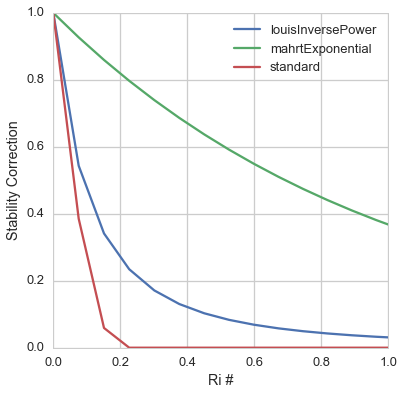

In [12]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
for stab in stabilitySchemes:
    ax.plot(RiBulk,stabilitySchemes[stab],label=stab)
ax.legend(loc='best')
ax.set_ylabel('Stability Correction')
ax.set_xlabel('Ri #')
ax.set_xlim(0,1)
ax.set_ylim(0,1)

### Comparing turbpy package to previous functions:
- behavior seems consistent!
- Slightly less control (can't directly prescribe the bulk Richardson number, have to vary it through the air temperatre)

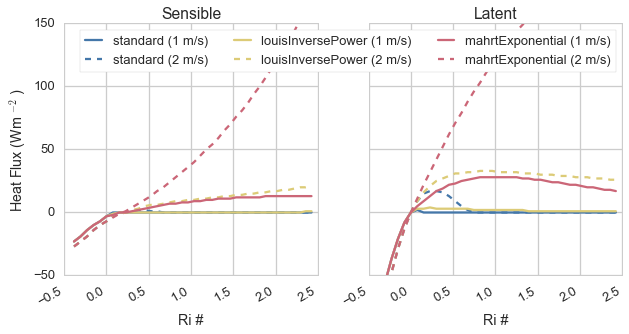

In [45]:
#######
# Plotting arguments
fig,axes = plt.subplots(1,2,sharey=True,figsize=(10,5))

# Plotting parameters
Qmax = 150
Qmin = -50
RiMax = 4
RiMin = -.1

########
# Bulk Richardson number
Ri = bulkRichardson(airtemp,
                    groundTemp,
                    windspd,
                    mHeight,
                    False)

colr = kgraph.SRON(3)

for sindex,stab in enumerate(ixStability):
    senHeatGround = np.zeros_like(airtemp)                  # sensible heat flux from ground surface (W m-2)
    latHeatGround = np.zeros_like(airtemp)                  # latent heat flux from ground surface (W m-2)

    (VPair,empty) = satVapPress(airtemp-273)
    VPair = VPair*.8

    for n,(tair,vp) in enumerate(zip(airtemp,VPair)):
        tfOut = turbFluxes(ixDerivMethod,stab,tair,airpres,vp,windspd,groundTemp,soilRelHumidity,mHeight)

        (_,        # ground conductance for sensible heat (m s-1)
        _,         # ground conductance for latent heat (m s-1)
        senHeatGround[n],               # sensible heat flux from ground surface (W m-2)
        latHeatGround[n],               # latent heat flux from ground surface (W m-2)
        _,              # net turbulent heat fluxes at the ground surface (W m-2)
        _,    # derivative in net turbulent fluxes w.r.t. ground temperature (W m-2 K-1)
        ) = tfOut
        
    ax = axes[0]
    ax.plot(Ri[0], latHeatGround,color=colr[sindex])
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlabel('Ri #')
    ax.set_ylabel('Heat Flux (Wm $^{-2}$ )')
    ax.set_title('Sensible')

    ax = axes[1]
    ax.plot(Ri[0], senHeatGround,color=colr[sindex],label=stab+' (1 m/s)')
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlabel('Ri #')
    ax.set_title('Latent')
    ax.set_title('Net')
    
    
    for n,(tair,vp) in enumerate(zip(airtemp,VPair)):
        tfOut = turbFluxes(ixDerivMethod,stab,tair,airpres,vp,2.,groundTemp,soilRelHumidity,mHeight)

        (_,        # ground conductance for sensible heat (m s-1)
        _,         # ground conductance for latent heat (m s-1)
        senHeatGround[n],               # sensible heat flux from ground surface (W m-2)
        latHeatGround[n],               # latent heat flux from ground surface (W m-2)
        _,              # net turbulent heat fluxes at the ground surface (W m-2)
        _,    # derivative in net turbulent fluxes w.r.t. ground temperature (W m-2 K-1)
        ) = tfOut
        
    ax = axes[0]
    ax.plot(Ri[0], latHeatGround,'--',color=colr[sindex])
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlabel('Ri #')
    ax.set_ylabel('Heat Flux (Wm $^{-2}$ )')
    ax.set_title('Sensible')

    ax = axes[1]
    ax.plot(Ri[0], senHeatGround,'--',color=colr[sindex],label=stab+' (2 m/s)')
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlabel('Ri #')
    ax.set_title('Latent')
    ax.legend(loc='upper right',frameon=True,ncol = 3,handlelength=1.3)

fig.autofmt_xdate()
fig.savefig('AMTS547.OfflineTurb.Idealized.pdf')